In [9]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

### Cleaning data

In [5]:
# load raw data}
df = pd.read_csv('milknew.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [7]:
# rename misspelled column
df = df.rename(columns={"Temprature": "Temperature", "Fat ": "Fat"})

# encode Grade with ordered mapping instead of alphabetical
grade_mapping = {'low': 0, 'medium': 1, 'high': 2}
df['Grade'] = df['Grade'].map(grade_mapping)

df.head()

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,2
1,6.6,36,0,1,0,1,253,2
2,8.5,70,1,1,1,1,246,0
3,9.5,34,1,1,0,1,255,0
4,6.6,37,0,0,0,0,255,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           1059 non-null   float64
 1   Temperature  1059 non-null   int64  
 2   Taste        1059 non-null   int64  
 3   Odor         1059 non-null   int64  
 4   Fat          1059 non-null   int64  
 5   Turbidity    1059 non-null   int64  
 6   Colour       1059 non-null   int64  
 7   Grade        1059 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 66.3 KB


In [11]:
# checking for class imbalance - slightly imbalanced, but can't use SMOTE since there's not enough data for good interpolation
df_filtered = df.drop_duplicates()
df_filtered['Grade'].value_counts()

Grade
1    34
0    26
2    23
Name: count, dtype: int64

### Visualizing distributions
note: different scales

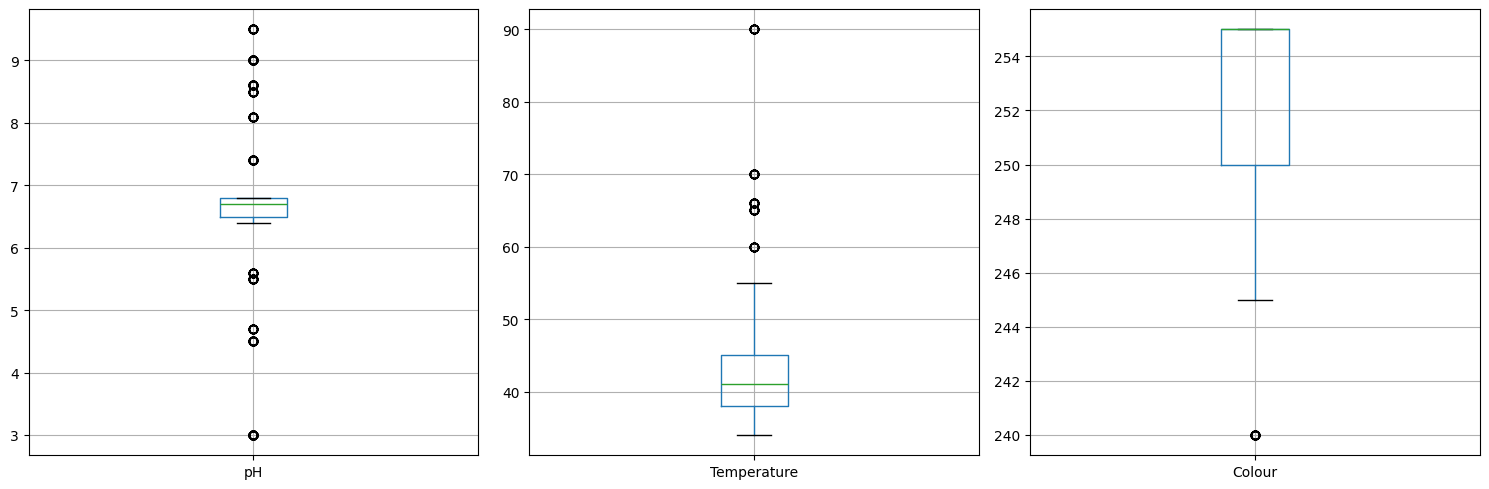

In [13]:
# plot boxplots
columns = ['pH', 'Temperature', 'Colour']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    df.boxplot(col, ax=axes[i])

plt.tight_layout()  
plt.show()

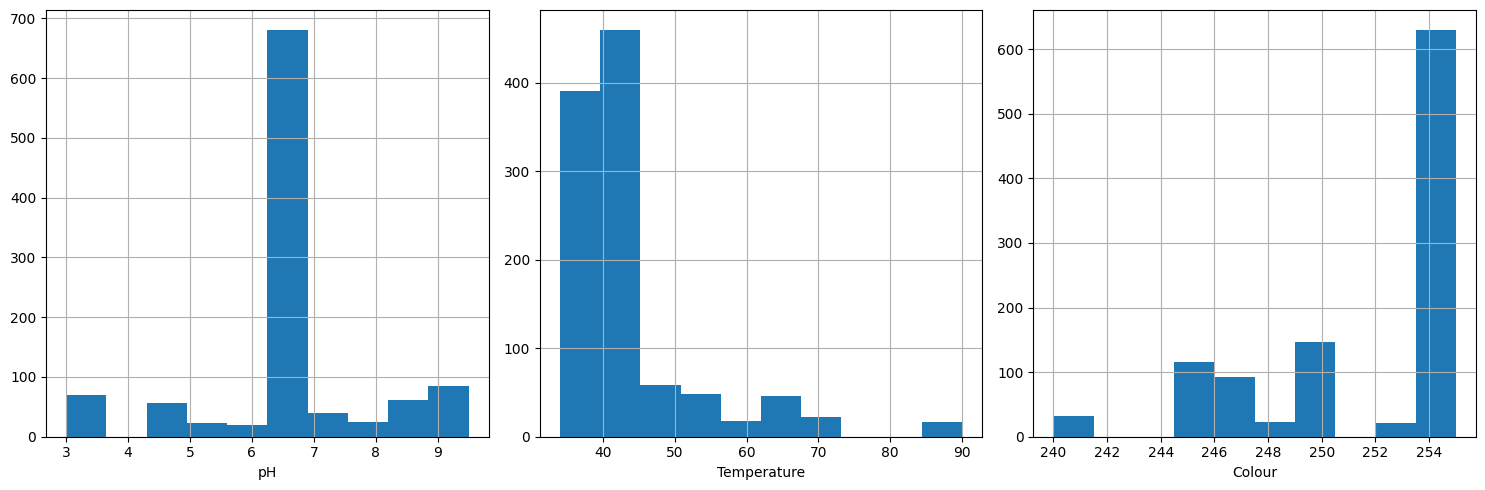

In [14]:
# plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    df[col].hist(ax=axes[i])  
    axes[i].set_xlabel(col) 

plt.tight_layout()
plt.show()

In [15]:
df.describe() # alternative compare distributions

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415,0.836638
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424,0.787868
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000,0.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000,0.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000,1.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000,1.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000,2.000000


### Train/test splitting (80/20) + normalization

In [15]:
from sklearn.model_selection import train_test_split

def transform(df, drop=False):
    # separate numerical and categorical columns
    numerical_cols = ['pH', 'Temperature', 'Colour']
    categorical_cols = ['Taste', 'Odor', 'Fat', 'Turbidity']
    
    # initialize and fit the MinMaxScaler
    scaler = MinMaxScaler() 

    if drop:
        df = df.drop_duplicates()

    # separate features from target variable
    X = df[numerical_cols + categorical_cols]
    y = df['Grade']

    if drop:
        # scale numerical features (note: no train-test split, so entire dataset is scaled at once)
        X_scaled = scaler.fit_transform(X[numerical_cols])
        X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)

        # concatenate numerical & categorical features
        X_final = pd.concat([X_scaled_df, X[categorical_cols].reset_index(drop=True)], axis=1)

        # return full dataset for k-fold CV usage
        return pd.concat([X_final, y.reset_index(drop=True)], axis=1)
        
    else: # keep duplicates
        # split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # fit and transform the numerical data on training data ONLY (avoid data leakage)
        X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols)
        
        # transform the numerical data for the test set
        X_test_scaled = scaler.transform(X_test[numerical_cols])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols)
        
        # combine the scaled numerical data with the categorical columns
        X_train_final = pd.concat([X_train_scaled_df, X_train[categorical_cols].reset_index(drop=True)], axis=1)
        X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_cols].reset_index(drop=True)], axis=1)
    
        train_df = pd.concat([X_train_final, y_train.reset_index(drop=True)], axis=1)
        test_df = pd.concat([X_test_final, y_test.reset_index(drop=True)], axis=1)
    
        return train_df, test_df

In [18]:
filtered_data_full = transform(df, drop=True)
filtered_data_full.info()

filtered_data_full.to_csv('filtered_data_full.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           83 non-null     float64
 1   Temperature  83 non-null     float64
 2   Colour       83 non-null     float64
 3   Taste        83 non-null     int64  
 4   Odor         83 non-null     int64  
 5   Fat          83 non-null     int64  
 6   Turbidity    83 non-null     int64  
 7   Grade        83 non-null     int64  
dtypes: float64(3), int64(5)
memory usage: 5.3 KB


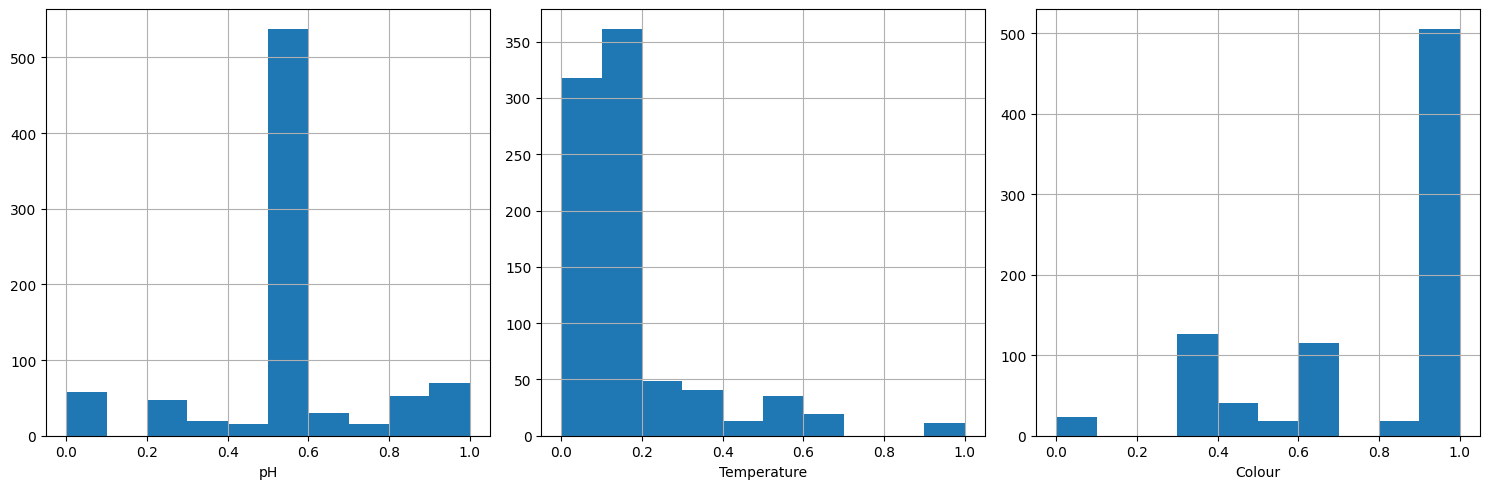

In [19]:
# view transformed distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    X_train_final[col].hist(ax=axes[i])  
    axes[i].set_xlabel(col) 

plt.tight_layout()
plt.show()

### View correlations?

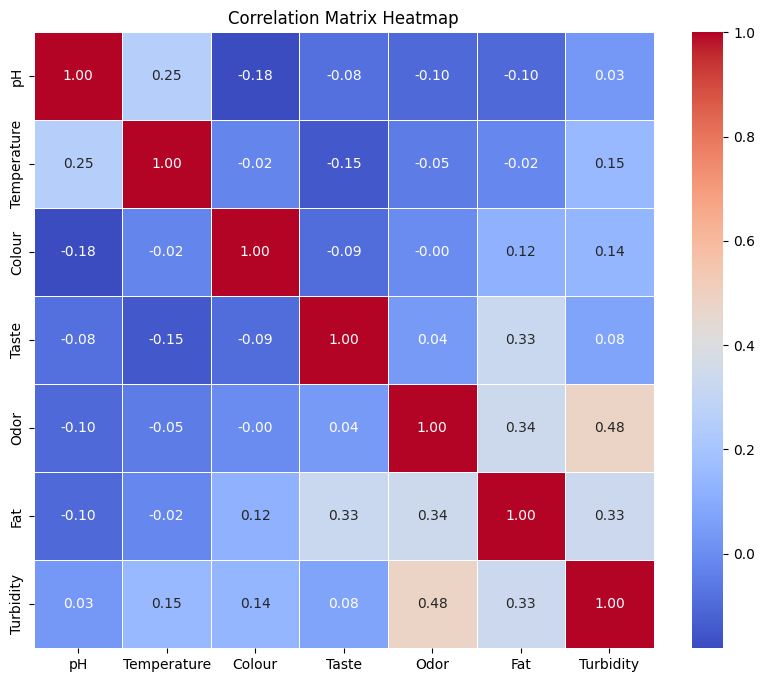

In [20]:
import seaborn as sns

# calculate correlation matrix
corr_matrix = X_train_final.corr()

# visualize using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

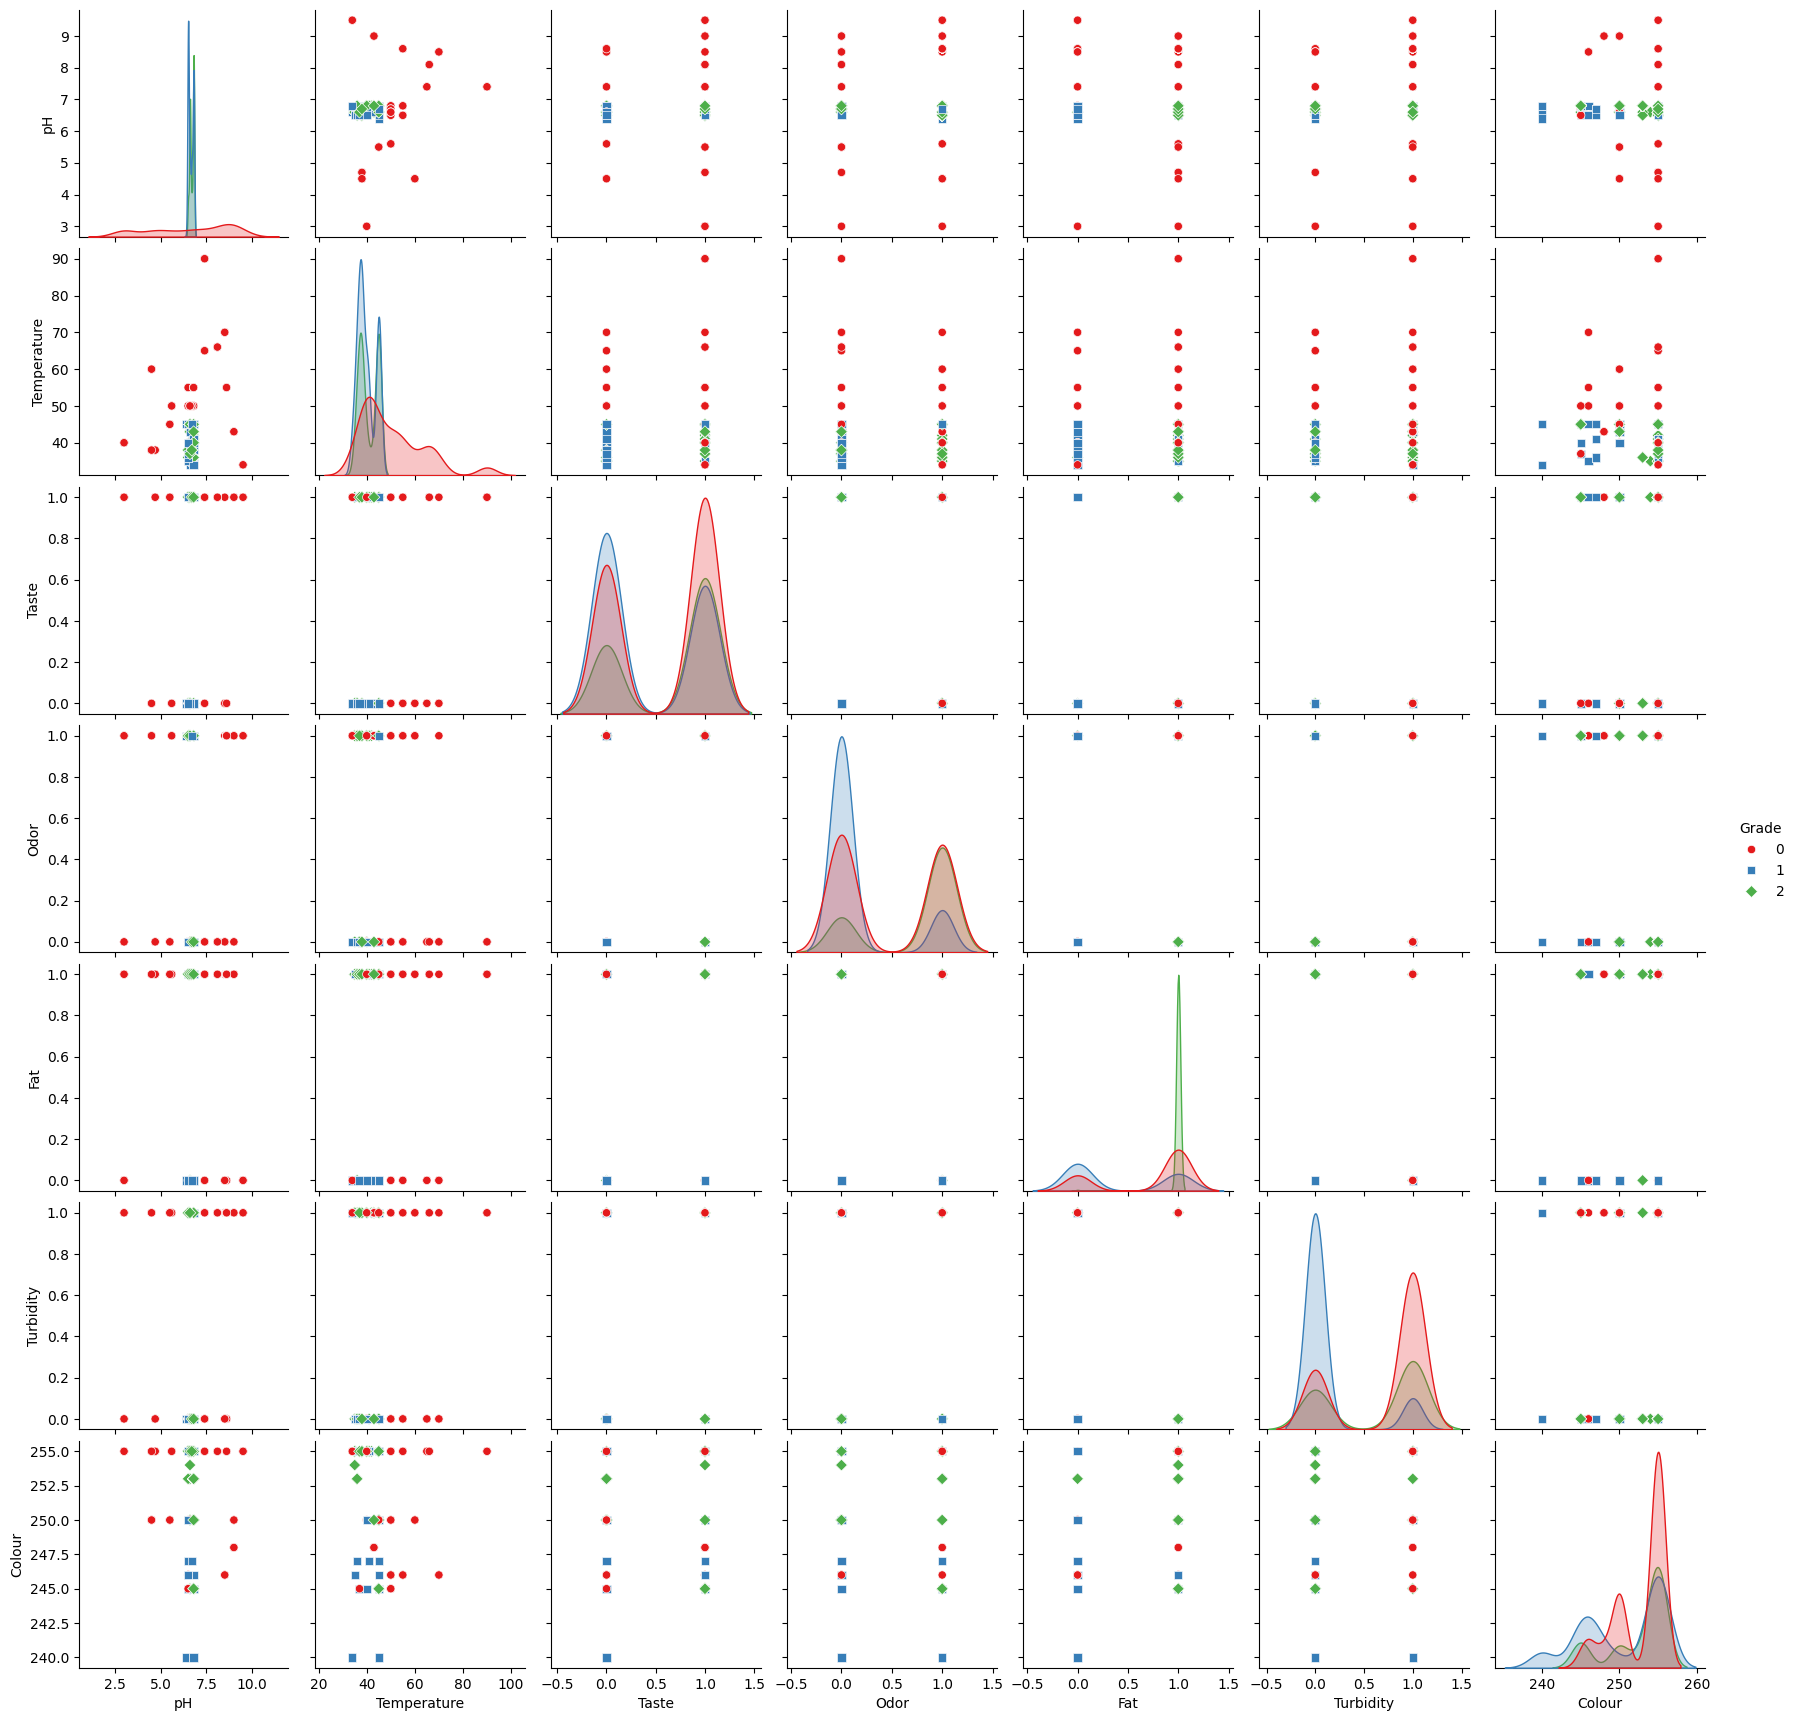

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, hue="Grade", markers=["o", "s", "D"], palette="Set1")
plt.show()

### Export data

In [21]:
train_df, test_df = transform(df, drop=False)

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)